# IXO Modelling

**Terminology:**

Tokens:
* c_ - IXO-Cosmos equivalent of Ethereum tokens
* native - native to IXO-Cosmos network
* cIXOS - staking tokens 
* cIXO - utility tokens

Mechanisms:
* Pool: pool of specific token / collateral type
* Bridge: pre-IBC mirror between Ethereum and IXO-Cosmos, implementation is irrelevant for now
* Supply Pool/Market maker: issues IXO tokens in exchange for DAI
* Liquidity Pool/Brokerage: issues IXOS / staking tokens to delegators

Network:
* nodes represent mechanisms, pools, and participants
* edges represent relationships, such as token balances, amongst mechanisms, pools, and participants
* the total pool balance is the sum of all edges conected to that pool

**Actor flow:**

1. Participant buys into market maker with Dai, and is given Ethereum based IXO tokens.
2. Participant stakes IXO into the brokerage mechanism in exchange for IXOS. The IXO stake is backed by a proportion of the DAI collateral pool.
3. The IXO and IXOS pools are mirrored on the IXO-Cosmos network, and backed by DAI - post IBC these assets can be made native to the IXO-Cosmos network.
4. cIXO become utility tokens that can be spent in IXO-Cosmos network, and minted through block rewards to be rewarded to actors in the system. The utility comes from the asset backing of the cIXO tokens in the brokerage.

**Working example:**

1. Participant purchases 100 IXO tokens @ 0.1 DAI per IXO for a total of 10 DAI.
2. Participant provides liquidity in brokerage contract by depositing 50 IXO, retaining 50 IXO for the time being. The asset backing is provided by the bonding curve Dai collateral pool.
3. Participant is rewarded with 50 IXOS tokens to represent the proportion of the liquidity provided.
4. These IXOS tokens are mirrored and can be used within the IXO-Cosmos network as equivalent cIXOS tokens, these are low velocity and are essentially staked for IXO-Cosmos incentive rewards.
5. Participants within the IXO-Cosmos network, who are incentivized/rewarded with cIXO tokens for supporting the network roles, may atomic swap/mirror their cIXO tokens for IXO tokens and in effect DAI via the bonding curve.

**Observations:**

* Based on last two actions - what is the best way to couple the cIXO token value to the DAI reserve to maintain the cross blockchain peg?
* Objective - make the cIXO utility token stable.
* cIXOS staked on IXO-Cosmos side for various incentive rewards.

![system-diagram](./ixo-liquidity-diagram_v2.png)

### Dependancies

In [1]:
from modules import *
%matplotlib inline

### Liquidity Mechanisms and Actors Overview

In [2]:
from enum import Enum, auto
class Nodes(Enum):
    POOL = auto() # Pool of specific token / collateral
    FEE_POOL = auto() # Black-box for fee collection
    STAKE_POOL = auto() # Black-box for stake collection
    # Mechanisms
    MARKET_MAKER = auto() # Issues IXO tokens in exchange for DAI
    BROKERAGE = auto() # Issues IXOS / staking tokens to delegators
    ARBITRAGE = auto()
    # Actors
    SERVICE_PROVIDER = auto() # makes claims about contributions and state of project
    EVALUATOR = auto() # validates claims
    DELEGATOR = auto() # stakes into the brokerage to provide liquidity
    PARTICIPANT = auto() # generic type for any user of IXO-Cosmos utility tokens
    # Generic actors
    GENERIC_DELEGATOR = auto()
    GENERIC_PARTICIPANT = auto()
    
class Edges(Enum):
    BALANCE = auto()
    BRIDGE = auto() # IBC style mirror
    
# IBC Ethereum Peg-Zone:
# 1. IXO from AMM and DAI staked into reserve pool by delegators in exchange for IXOS
# 2. cIXO and cIXOS matched on IXO-Cosmos network
# 3. This mechanism can be spun down, while maintaining the liquidity created, when the IBC mechanism is operational

### Global Parameters

In [3]:
tax = 0 # exit tax - introduces friction and possibly funds to prime stability mechanisms
theta = 0 #.35 # Funding pool taxation - 0 implies all contributions allocated to market

# Supply pool initial parameters
initial_ixo_supply = 1660495658
initial_ixo_price = .15 #.03 # average IXO price from ixo.world Euro cents
initial_ixo_reserve = initial_ixo_supply * initial_ixo_price

# Founders staked at 1:10 -- where DAI/IXO pair are entered into liquidity pool to receive staking vouchers, founders receive 1/10th of the value or share of the pool
# founders_stake = .1 # percent
initial_ixos_supply = 100_000_000 # initial_ixo_supply * founders_stake # initial supply of staking vouchers

initial_ixos_price = .20 # staking voucher price from AMM in Euro cents

ixo_delegation_distribution_reserve = 1e6
ixo_delegation_distribution_supply = 1e6/initial_ixos_price #200e6 # 5 strategic delegations worth Euro 1 Mil each

# Augmented bonding curve parameters
# Hatch state
d0 = initial_ixo_reserve/1e6 # million DAI
p0 = initial_ixo_price # DAI per token

R0 =  d0*(1-theta) # million DAI
S0 = d0/p0

# Brokerage - Kyber Fed Price Reserve
# Policy to bound proposed conversion rate
sanity_rate = 10 # 1 DAI = 10 IXO
reasonable_difference = .1 # percent

# Target portfolio
# 50% DAI / 50% IXO

# Rebalancing
# Or: auto_instant - rebalance performed after every trade
time_spacing = 1 # time period after which to perform another rebalance
price_spacing_diff = .5 # percentage difference from last rebalance after which to perform another rebalance

# Pricing
maximum_spread = 0.02 # dictated by for example Kyber
minimum_spread = 0.005
spread = 0.01 # dependant on liquidity
quoted_price = 0 # TODO

# cadCAD configuration
days_in_month = 30 # approx.
time_steps = 12*days_in_month # days for more granularity - NB: all transaction rates in days

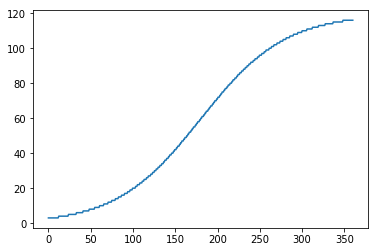

In [4]:
# Number of actors
# max_delegators = 20
# max_validators = 20
# max_service_providers = 20
max_participants = 120 # conservative

# Sigmoidal growth
default_inflection = time_steps/2
default_slope = 1/50

def sigmoidal_growth(step, max_value, inflection=default_inflection, slope=default_slope):
    y = np.divide(max_value, (1 + np.power(np.e, -np.multiply(np.subtract(step, inflection), slope))))
    y = np.floor(y)
    y[y < 0] = 0
    return y

x = np.linspace(0, time_steps, 500)
y = sigmoidal_growth(x, max_participants)

plt.plot(x, y)
plt.show()

### cadCAD Parameters and Initial State

In [5]:
# cadCAD Parameter Sets
#####################################################################

# amm == automated market maker
# brk == brokerage

# TODO: this is cleaner/readable, but cadCAD doesn't seem to handle it - potential PR
# params = {
#     'brokerage': {
#         'sanity_rate': 10,
#         'max_spread': .02,
#     }
# }
# 'supply_pool': [
#     {
#         'tx_rate': 0,
#         'tx_count': 6,
#         'tx_value': 1e6,
#     }
# ],
# 'liquidity_pool': [
#     {
#         'tx_rate': .33,
#         'tx_count': 0,
#         'tx_value': 100e3,
#     }
# ],

def sweep_range(params):
    max_len = 1
    for key in params:
        param_length = len(params[key])
        if param_length > max_len:
            max_len = param_length
    return list(range(1, max_len + 1)) or [1] 

params = {
    # Automated Market Maker parameters
    'amm.kappa': [1.2],
    'amm.tax_rate': [0.02, 0.50],
    'amm.theta': [0],
    # Arbitrage
    'arbitrage_roi': [0.05], # False == no arbitrage
    # Brokerage
    'brk.trade_fee': [0.02],
    'brk.sanity_rate': [10], # 1 DAI = 10 IXO
    'brk.reasonable_diff': [.5], # percent
    'brk.rebalance_diff': [False], # percentage difference from last rebalance after which to perform another rebalance
    'brk.max_spread': [.02], # price
    'brk.min_spread': [.005],
    # Transactions
    'max_participants': [max_participants],
    'participant_seed_collateral': [500],
    'supply_pool_tx_rate': [0],
    'supply_pool_tx_count': [5],
    'supply_pool_tx_value': [1e6],
    #'liquidity_pool_tx_rate': [.33],
    #'liquidity_pool_tx_count': [0],
    #'liquidity_pool_tx_value': [100e3],
    # Fees
    'daily_service_fee': [2], # daily fee (IXO) for users of system for gas and services, sent to fee pool black-box e.g. 2 IXO == 0.2 DAI cents, or 6 DAI/month 
}

params['sweep'] = sweep_range(params) # for selecting parameter sweep from results - unique ID

initial_state = {
    'valid_system_state': True,
    'amm.supply': 0,
    'amm.reserve': 0,
    'amm.spot_price': 0,
    'amm.invariant': 0,
    'lp.supply': 0,
    'lp.reserve': 0,
    'lp.spot_price': 0,
    'lp.voucher_price': 0,
}

params['sweep']

[1, 2]

### Brokerage / liquidity framework

In [6]:
# Brokerage framework / liquidity provision (see Uniswap/Kyber)
# https://github.com/runtimeverification/verified-smart-contracts/blob/uniswap/uniswap/x-y-k.pdf
# Newly added... found post setting this up: https://github.com/BlockScience/uniswap

# e.g. reserve == DAI
# e.g. supply == IXO
# e.g. voucher == IXOS

def add_liquidity(reserve_balance, supply_balance, voucher_balance, tokens, value):    
    print('voucher_balance %s' % voucher_balance)
    if voucher_balance <= 0:        
        dr = value
        ds = tokens
        dv = tokens
        return (dr, ds, dv)
    
    alpha = value/reserve_balance
    
    dr = alpha*reserve_balance
    ds = alpha*supply_balance
    dv = alpha*voucher_balance
    
    #new_reserve = (1 + alpha)*reserve_balance
    #new_supply = (1 + alpha)*supply_balance
    #new_vouchers = (1 + alpha)*voucher_balance
    
    return (dr, ds, dv)

def remove_liquidity(reserve_balance, supply_balance, voucher_balance, tokens):
    alpha = tokens/voucher_balance
    
    dr = -alpha*reserve_balance
    ds = -alpha*supply_balance
    dv = -alpha*voucher_balance
    
    #new_reserve = (1 - alpha)*reserve_balance
    #new_supply = (1 - alpha)*supply_balance
    #new_liquidity_tokens = (1 - alpha)*liquidity_token_balance
    
    return (dr, ds, dv)

# How much y received for selling dx?
def get_input_price(dx, x_balance, y_balance, trade_fee=0.01):
    rho = trade_fee
    
    alpha = dx/x_balance
    gamma = 1 - rho
    
    dy = (alpha*gamma / (1 + alpha*gamma))*y_balance
    
    _dx = alpha*x_balance
    _dy = -dy
    
    #new_x = (1 + alpha)*x_balance
    #new_y = y_balance - dy
    
    return (_dx, _dy)

# How much x needs to be sold to buy dy?
def get_output_price(dy, x_balance, y_balance, trade_fee=0.01):
    rho = trade_fee
    
    beta = dy/y_balance
    gamma = 1 - rho
    
    dx = (beta / (1 - beta))*(1 / gamma)*x_balance
    
    _dx = dx
    _dy = -beta*y_balance
    
    #new_x = x_balance + dx
    #new_y = (1 - beta)*y_balance
    
    return (_dx, _dy)

# Token trading
def collateral_to_token(value, reserve_balance, supply_balance, trade_fee):
    if reserve_balance == 0: return 0 #TODO: handle this case better
    dx,dy = get_input_price(value, reserve_balance, supply_balance, trade_fee)
    
    #new_reserve = reserve_balance + dx
    #new_supply = supply_balance - dy
    
    return abs(dy)

def token_to_collateral(tokens, reserve_balance, supply_balance, trade_fee):
    if supply_balance == 0: return 0 #TODO: handle this case better
    dx,dy = get_input_price(tokens, supply_balance, reserve_balance, trade_fee)
    
    #new_reserve = reserve_balance - dx
    #new_supply = supply_balance + dy
    
    return abs(dy)

def token_to_token():
    # Irrelevant for now
    return False

### Initialize System

In [7]:
# Node generators
def add_new_pool(
        network,
        ticker):
    
    network.add_node(ticker, _type=Nodes.POOL.name)
    return network
        
def add_liquidity_mechanism(
        network,
        _params,
        pair=('DAI', 'IXO')):
    
    pair_id = generate_pair_id(Nodes.BROKERAGE, pair)
    network.add_node(pair_id, _type=Nodes.BROKERAGE.name)
    network.add_edge(pair_id, pair[0], _type=Edges.BALANCE.name, balance=0) # reserve: DAI
    network.add_edge(pair_id, pair[1], _type=Edges.BALANCE.name, balance=0) # supply: IXO
    
    brokerage = {}
    brokerage['target'] = .5 # Target portfolio pair[0]:pair[1]
    brokerage['rate'] = _params['brk.sanity_rate'] #TODO
    brokerage['sanity_rate'] = _params['brk.sanity_rate']
    brokerage['reasonable_diff'] = _params['brk.reasonable_diff']
    brokerage['rebalance_diff'] = _params['brk.rebalance_diff']
    brokerage['max_spread'] = _params['brk.max_spread']
    brokerage['min_spread'] = _params['brk.min_spread']
    brokerage['reserve_type'] = pair[0]
    brokerage['supply_type'] = pair[1]
    brokerage['voucher_type'] = pair[1] + 'S' # can be made more robust
    
    network.nodes[pair_id].update(brokerage)
    return network

def add_supply_mechanism(
        network,
        _params,
        initial_reserve,
        initial_supply,
        initial_spot_price,
        initial_invariant,
        pair=('DAI', 'IXO')): # Collateral -> distributed token
    
    pair_id = generate_pair_id(Nodes.MARKET_MAKER, pair)
    network.add_node(pair_id, _type=Nodes.MARKET_MAKER.name)
    
    network.add_edge(pair_id, pair[0], _type=Edges.BALANCE.name, balance=0)
    network.add_edge(pair_id, pair[1], _type=Edges.BALANCE.name, balance=0)
    
    market_maker = {}
    market_maker['pair'] = pair # Reserve/collateral -> supply/token
    market_maker['reserve_type'] = pair[0]
    market_maker['supply_type'] = pair[1]
    market_maker['kappa'] = _params['amm.kappa']
    market_maker['invariant'] = initial_invariant
    market_maker['tax_rate'] = _params['amm.tax_rate']
    market_maker['spot_price'] = initial_spot_price
    
    # Initialize pools
    reserve_edge = network.edges[(pair_id, market_maker['reserve_type'])]
    supply_edge = network.edges[(pair_id, market_maker['supply_type'])]
    reserve_edge['balance'] = initial_reserve
    supply_edge['balance'] = initial_supply
    
    network.nodes[pair_id].update(market_maker)
    return network

def add_new_bridge(
        network,
        _params=params,
        pair=('IXO', 'cIXO')):
    
    network.add_edge(pair[0], pair[1], _type=Edges.BRIDGE.name, balance=0)

def add_new_actor(
        network,
        _type,
        _params=params):
    
    _id = len([node for node in network.nodes])
    network.add_node(_id, _type=_type)
    
    actor = {}
    actor['key'] = 'value'
    
    network.node[_id].update(actor)
    
    return _id

def initialize_network():
    network = nx.Graph()
    color_map = []
    
    pools = ['IXOS','cIXOS']
    
    for ticker in pools:
        color_map.append('orange')
        add_new_pool(network, ticker)
        
    bridges = [
        ('DAI', 'cDAI'),
        ('IXO', 'cIXO'),
        ('IXOS', 'cIXOS'),
    ]
    
    for pair in bridges:
        add_new_bridge(network, params, pair)
        
    generic_actor_types = [
        Nodes.GENERIC_DELEGATOR.name,
        Nodes.GENERIC_PARTICIPANT.name,
    ]
    
    for actor_type in generic_actor_types:
        _id = add_new_actor(network, actor_type)
    
    # Seed arbitrage mechanism with 10000 DAI
    _id = add_new_actor(network, Nodes.ARBITRAGE.name)
    network.add_edge(_id, 'DAI', _type=Edges.BALANCE.name, balance=10000)
    network.add_edge(_id, 'IXO', _type=Edges.BALANCE.name, balance=100000)
    # Add fee collection mechanism
    _id = add_new_actor(network, Nodes.FEE_POOL.name)
    network.add_edge(_id, 'IXO', _type=Edges.BALANCE.name, balance=0)
    # Add stake collection mechanism
    _id = add_new_actor(network, Nodes.STAKE_POOL.name)
    network.add_edge(_id, 'IXOS', _type=Edges.BALANCE.name, balance=0)
        
    return (network, color_map)

def network_genesis(network, _params, state):
    #'amm.supply': initial_ixo_supply,
    #'amm.reserve': amm_initial_reserve,
    #'amm.spot_price': amm_initial_spot_price,
    initial_supply = initial_ixo_supply
    initial_reserve, initial_invariant, initial_spot_price = \
        initialize_bonding_curve(initial_ixo_supply, initial_price=initial_ixo_price, kappa=_params['amm.kappa'], theta=_params['amm.theta'])
    
    brokerage_pairs = [
        ('DAI','IXO'),
        ('cDAI','cIXO')
    ]
    
    for pair in brokerage_pairs:
        for ticker in pair:
            add_new_pool(network, ticker)
        color_map.append('pink')
        add_liquidity_mechanism(network, _params, pair)
        
    market_maker_pairs = [('DAI','IXO')]
    
    for pair in market_maker_pairs:
        for ticker in pair:
            add_new_pool(network, ticker)
        add_supply_mechanism(network, _params, initial_reserve, initial_supply, initial_spot_price, initial_invariant, pair)
        
    return network

## Helpers

In [8]:
def transfer(network, _from, _to, _value, _type, failsafe=False):
    assert(_value > 0)
    balance = network.edges[(_from, _type)]['balance']
    if not failsafe and not balance >= _value:
        print('Balance %s; Value %s' % (balance, _value))
        raise AssertionError('Insufficient balance')
    elif not network.edges[(_from, _type)]['balance'] >= _value:
        print('Balance %s; Value %s' % (balance, _value))
        print('Insufficient balance')
        return (False, balance)
    else:
        network.edges[(_from, _type)]['balance'] -= _value
        if not network.has_edge(_to, _type):
            network.add_edge(_to, _type, _type=Edges.BALANCE.name, balance=0)
        network.edges[(_to, _type)]['balance'] += _value
        return (True, _value)

def get_pool_balance(network, pool_node, filter_type=[None]):
    if not None in filter_type:
        edges = [(x,y) for x,y,z in network.edges(pool_node, data=True) 
                 if network.nodes[x].get('_type', None) in filter_type 
                 or network.nodes[y].get('_type', None) in filter_type]
    else:
        edges = network.edges(pool_node)
    balance = sum([network.edges[edge].get('balance', 0) for edge in edges])
    assert(balance >= 0)
    return balance

def balance_of(network, holder, pool, default=0):
    balance = network.edges[(holder, pool)].get('balance', default)
    assert(balance >= 0)
    return balance

def valid_system_state(s):
    return s['valid_system_state']

def invalidate_system_state():
    return ('valid_system_state', False)

## Policies

In [9]:
expon.rvs(size=10, loc=0.0, scale=100)

array([ 73.63763674,  42.71365959, 136.91777253,  81.91006722,
       166.63011957,  31.11546627,  37.90113488,   1.74274575,
        21.1345453 ,  41.32867772])

In [10]:
def check_genesis(_params, step, sL, s):
    if not valid_system_state(s): return ({})
    genesis = False
    if s['timestep'] == 0:
        print('Genesis')
        genesis = True
        
    return ({'genesis': genesis})

def driving_process(_params, step, sL, s):
    if not valid_system_state(s): return ({})
    network = s['network']
    
    participants = get_node_ids_of_type(network, Nodes.PARTICIPANT.name)
    participant_growth = sigmoidal_growth([s['timestep']], _params['max_participants'])[0]
    new_participants = math.ceil(participant_growth - len(participants))
    
    if new_participants:
        zipOf = zip(range(new_participants), expon.rvs(size=new_participants, loc=0.0, scale=_params['participant_seed_collateral']))
        new_participants_collateral = dict(zipOf)
    else:
        new_participants_collateral = {}
    
    return({'new_participants': new_participants,
            'new_participants_collateral': new_participants_collateral})

def participant_process(params, step, sL, s):
    if not valid_system_state(s): return ({})
    network = s['network']
    
    participants = get_node_ids_of_type(network, Nodes.PARTICIPANT.name)
    brokers = get_node_ids_of_type(network, Nodes.BROKERAGE.name)
    participants_with_collateral = filter(lambda p: network.edges[(p, 'DAI')].get('balance', 0)>0, participants)
    
    transactions = []
    for p in participants_with_collateral:
        transactions.append({
            'from': p,
            'type': 'DAI',
            'handler': ('DAI', 'IXO'),
            # Transfer all DAI holdings to brokerage, in exchange for IXO
            'value': network.edges[(p, 'DAI')]['balance'],
        })
    
    return({'transactions': transactions})

def supply_pool_process(_params, step, sL, s):
    if not valid_system_state(s): return ({})
    network = s['network']
    
    generic_actor_type = Nodes.GENERIC_DELEGATOR.name
    actor = get_node_ids_of_type(network, generic_actor_type)[0]
    
    tx_rate = _params['supply_pool_tx_rate']
    tx_count = _params['supply_pool_tx_count']
    tx_value = _params['supply_pool_tx_value']
    
    perform_tx = False
    if tx_rate:
        perform_tx = s['timestep'] % (tx_rate*time_steps) < 1
    elif tx_count:
        perform_tx = s['timestep'] % (time_steps/tx_count) < 1
    else:
        raise
    
    transactions = []
    if perform_tx: # NB: this holds assuming less than 1 tx per day
        if not network.has_edge(actor, 'DAI'):
            network.add_edge(actor, 'DAI', _type=Edges.BALANCE.name, balance=0)
        network.edges[(actor, 'DAI')]['balance'] += 2*tx_value # mint DAI for IXO, and liquidity provision
        transactions.append({
            'from': actor,
            'type': 'DAI',
            'handler': ('DAI', 'IXO'),
            # Transfer all DAI collateral holdings to DAI:IXO market maker
            'value': tx_value,
        })
    
    return({'transactions': transactions})

def liquidity_pool_process(_params, step, sL, s):
    if not valid_system_state(s): return ({})
    network = s['network']
    
    generic_actor_type = Nodes.GENERIC_DELEGATOR.name
    actor = get_node_ids_of_type(network, generic_actor_type)[0]
    
    tx_rate = _params['supply_pool_tx_rate']
    tx_count = _params['supply_pool_tx_count']
    
    perform_tx = False
    if tx_rate:
        perform_tx = s['timestep'] % (tx_rate*time_steps) < 1
    elif tx_count:
        perform_tx = s['timestep'] % (time_steps/tx_count) < 1
    else:
        raise
    
    transactions = []
    if perform_tx: # NB: this holds assuming less than 1 tx per day
        tx_value = balance_of(network, actor, 'IXO') #_params['supply_pool_tx_value']
        transactions.append({
            'from': actor,
            'type': generate_pair_id(Nodes.BROKERAGE, ('DAI', 'IXO')),
            'handler': ('DAI', 'IXO'),
            # Transfer DAI equivalent of IXO holdings to liquidity pool 
            'value': tx_value,
        })
    
    return({'transactions': transactions})

def arbitrage_process(_params, step, sL, s):
    if not valid_system_state(s): return ({})
    network = s['network']
    
    generic_actor_type = Nodes.ARBITRAGE.name
    actor = get_node_ids_of_type(network, generic_actor_type)[0]
    
    supply_handler_id = generate_pair_id(Nodes.MARKET_MAKER, ('DAI', 'IXO'))
    supply_handler = network.nodes[supply_handler_id]
    liquidity_handler_id = generate_pair_id(Nodes.BROKERAGE, ('DAI', 'IXO'))
    liquidity_handler = network.nodes[liquidity_handler_id]
    
    supply_pool_reserve = balance_of(network, supply_handler_id, 'DAI')
    supply_pool_supply = get_pool_balance(network, 'IXO')
    liquidity_pool_reserve = balance_of(network, liquidity_handler_id, 'DAI')
    liquidity_pool_supply = balance_of(network, liquidity_handler_id, 'IXO')
    
    V0 = invariant(
            supply_pool_reserve,
            supply_pool_supply,
            supply_handler['kappa'])
    
    # DAI -> Mint IXO -> perform swap for DAI via liquidity pool
    spot_price_supply_pool = spot_price(supply_pool_reserve, V0, supply_handler['kappa'])
    spot_price_liquidity_pool = token_to_collateral(1, liquidity_pool_reserve, liquidity_pool_supply, _params['brk.trade_fee'])

    arbitrage = False
    if spot_price_liquidity_pool > spot_price_supply_pool:
        tx_value = min(1000, balance_of(network, actor, 'DAI'))
        if liquidity_pool_supply > 0 and liquidity_pool_reserve > 0 and tx_value > 0:
            ds,realized_price = mint(tx_value, supply_pool_reserve, supply_pool_supply, V0, supply_handler['kappa'])
            dr = token_to_collateral(ds, liquidity_pool_reserve, liquidity_pool_supply, _params['brk.trade_fee'])
            # Check if ROI greater than 2%
            if _params['arbitrage_roi'] and dr - tx_value > _params['arbitrage_roi']*tx_value:
                arbitrage = {
                    'from': actor,
                    'to': generate_pair_id(Nodes.MARKET_MAKER, ('DAI', 'IXO')),
                    'value': tx_value,
                    'realized_price': realized_price,
                    'ds': ds,
                    'dr': dr,
                }
    elif spot_price_liquidity_pool < spot_price_supply_pool:
        tx_value = min(10000, balance_of(network, actor, 'IXO'))
        if liquidity_pool_supply > 0 and liquidity_pool_reserve > 0 and tx_value > 0:
            ds = collateral_to_token(tx_value, liquidity_pool_reserve, liquidity_pool_supply, _params['brk.trade_fee'])
            dr,tax,realized_price = withdraw_with_tax(ds, supply_pool_reserve, supply_pool_supply, V0, supply_handler['tax_rate'], supply_handler['kappa'])
            # Check if ROI greater than 2%
            if _params['arbitrage_roi'] and dr - tx_value > _params['arbitrage_roi']*tx_value:
                arbitrage = {
                    'from': actor,
                    'to': generate_pair_id(Nodes.BROKERAGE, ('DAI', 'IXO')),
                    'value': tx_value,
                    'realized_price': realized_price,
                    'ds': ds,
                    'dr': dr,
                }
            
    return({'arbitrage': arbitrage})

def collect_fee_process(_params, step, sL, s):
    if not valid_system_state(s): return ({})
    network = s['network']
    
    value = _params['daily_service_fee']
    
    participants = get_node_ids_of_type(network, Nodes.PARTICIPANT.name)
    participants_with_ixo = list(filter(lambda p: network.has_edge(p, 'IXO') and network.edges[(p, 'IXO')].get('balance', 0)>value, participants))
    
    fees = {
        'value': value,
        'participants': participants_with_ixo,
    }
    
    return({'fees': fees})

def accounting(_params, step, sL, s):
    update = s['timestep'] > 1
    return({'update': update})

def sync(_params, step, sL, s):
    if not valid_system_state(s): return ({})
    return({'update': True})

## Mechanisms for updating the state based on driving processes

In [11]:
def perform_genesis(_params, step, sL, s, _input):
    if not valid_system_state(s): return ('','')
    network = s['network']
    
    genesis = _input['genesis']
    if genesis:
        print('Perform genesis')
        network = network_genesis(network, _params, s)
    
    key = 'network'
    value = network
        
    return (key, value)

def sync_bridges(_params, step, sL, s, _input):
    if not valid_system_state(s): return ('','')
    network = s['network']
    
    bridges = get_edge_ids_of_type(network, Edges.BRIDGE.name)
    for edge_id in bridges:
        bridge = network.edges[edge_id]
        bridge['balance'] = get_pool_balance(network, edge_id[0])
        print(bridge)
        
    key = 'network'
    value = network
        
    return (key, value)

def collect_fees(_params, step, sL, s, _input):
    if not valid_system_state(s): return ('','')
    network = s['network']
    
    generic_actor_type = Nodes.FEE_POOL.name
    fee_pool = get_node_ids_of_type(network, generic_actor_type)[0]
    
    fees = _input['fees']
    value = fees['value']
    participants = fees['participants']
    
    for participant in participants:
        transfer(network, participant, fee_pool, value, 'IXO')
        
    key = 'network'
    value = network
    
    return (key, value)

def perform_arbitrage(_params, step, sL, s, _input):
    if not valid_system_state(s): return ('','')
    network = s['network']
    
    #'from': actor,
    #'value': tx_value,
    #'realized_price': realized_price,
    #'ds': ds,
    #'dr': dr,
    arbitrage = _input['arbitrage']
    supply_handler_id = generate_pair_id(Nodes.MARKET_MAKER, ('DAI', 'IXO'))
    liquidity_handler_id = generate_pair_id(Nodes.BROKERAGE, ('DAI', 'IXO'))
    
    if arbitrage:
        actor = arbitrage['from']
        to = arbitrage['to']
        tx_value = arbitrage['value']
        realized_price = arbitrage['realized_price']
        ds = arbitrage['ds']
        dr = arbitrage['dr']
        
        supply_reserve_balance = balance_of(network, supply_handler_id, 'DAI')
        liquidity_reserve_balance = balance_of(network, liquidity_handler_id, 'DAI')
        
        if to == supply_handler_id:
            print('Perform arbitrage %s->%s: %s' % (supply_handler_id, liquidity_handler_id, arbitrage))
            if not network.has_edge(actor, 'IXO'):
                network.add_edge(actor, 'IXO', _type=Edges.BALANCE.name, balance=0)

            # Mint IXO
            transfer(network, actor, supply_handler_id, tx_value, 'DAI')
            network.edges[(actor, 'IXO')]['balance'] += ds

            # Swap for DAI
            if ds and balance_of(network, actor, 'IXO') >= ds and liquidity_reserve_balance >= dr:
                roi = dr/tx_value
                print('ROI %s' % roi)
                transfer(network, actor, liquidity_handler_id, ds, 'IXO')
                transfer(network, liquidity_handler_id, actor, dr, 'DAI')
        elif to == liquidity_handler_id:
            print('Perform arbitrage %s->%s: %s' % (liquidity_handler_id, supply_handler_id, arbitrage))
            # Swap for IXO
            transfer(network, actor, liquidity_handler_id, tx_value, 'DAI')
            transfer(network, liquidity_handler_id, actor, ds, 'IXO')
            
            # Withdraw for Dai
            if dr and balance_of(network, supply_handler_id, 'IXO') >= ds and supply_reserve_balance >= dr:
                roi = dr/tx_value
                print('ROI %s' % roi)
                network.edges[(supply_handler_id, 'IXO')]['balance'] -= ds
                transfer(network, supply_handler_id, actor, dr, 'DAI')
    
    key = 'network'
    value = network
    
    return (key, value)

def update_network(_params, step, sL, s, _input):
    if not valid_system_state(s): return ('','')
    network = s['network']
    
    new_participants = _input['new_participants'] # Number of
    new_participants_collateral = _input['new_participants_collateral'] # Dict
    
    for i in range(new_participants):
        _id = add_new_actor(network, Nodes.PARTICIPANT.name)
        # Deposit seed collateral
        network.add_edge(_id, 'DAI', balance=new_participants_collateral[i])
            
    key = 'network'
    value = network
    
    return (key, value)

def update_balances(_params, step, sL, s, _input):
    if not valid_system_state(s): return ('','')
    network = s['network']
    
    # Process transactions and update balances
    # [{'from': 10, 'type': 'DAI', 'handler': ('DAI', 'IXO'), 'value': 0}]
    transactions = _input['transactions']
    
    #print(transactions)
    for tx in transactions:
        handler_id = generate_pair_id(Nodes.MARKET_MAKER, tx['handler'])
        handler = network.nodes[handler_id]
        assert(handler['_type'] == Nodes.MARKET_MAKER.name)
        
        # Collateral -> token; e.g. DAI -> IXO
        participant = tx['from']
        reserve_pool = handler['reserve_type']
        supply_pool = handler['supply_type']
        reserve = balance_of(network, handler_id, handler['reserve_type'])
        supply = get_pool_balance(network, handler['supply_type'])

        if tx['type'] == reserve_pool: # Mint
            #print('Mint %s' % tx['value'])
            V0 = invariant(
                reserve,
                supply,
                handler['kappa'])
            deltaS, realized_price = mint(
                tx['value'],
                reserve,
                supply,
                V0,
                handler['kappa'])

            # Update holdings
            transfer(network, participant, handler_id, tx['value'], reserve_pool)
            if not network.has_edge(participant, supply_pool):
                network.add_edge(participant, supply_pool, _type=Edges.BALANCE.name, balance=0)
            network.edges[(participant, supply_pool)]['balance'] += deltaS
            
            # Update market maker
            handler['invariant'] = V0
            handler['spot_price'] = spot_price(
                reserve,
                handler['invariant'],
                handler['kappa'])

        elif tx['type'] == supply_pool: # Withdraw
            #print('Withdraw %s' % tx['value'])
            V0 = invariant(
                reserve,
                supply,
                handler['kappa'])
            deltaR, realized_price = withdraw(
                tx['value'],
                reserve,
                supply,
                V0,
                handler['kappa'])

            # Update holdings
            transfer(network, handler_id, participant, deltaR, reserve_pool)
            network.edges[(participant, supply_pool)]['balance'] -= tx['value']

            # Update market maker
            handler['invariant'] = V0
            handler['spot_price'] = spot_price(
                reserve,
                handler['invariant'],
                handler['kappa'])

        else: raise # We shouldn't get here
    
    key = 'network'
    value = network
    
    return (key, value)

def update_brokerage(_params, step, sL, s, _input):
    if not valid_system_state(s): return ('','')
    network = s['network']
    
    # Process transactions and update balances
    # [{'from': 10, 'type': 'DAI', 'handler': ('DAI', 'IXO'), 'value': 0}]
    transactions = _input['transactions']

    #print(transactions)
    for tx in transactions:
        handler_id = generate_pair_id(Nodes.BROKERAGE, tx['handler'])
        handler = network.nodes[handler_id]
        market_maker_id = generate_pair_id(Nodes.MARKET_MAKER, tx['handler'])
        market_maker = network.nodes[market_maker_id]
        assert(handler['_type'] == Nodes.BROKERAGE.name)
        
        # Collateral -> token; e.g. DAI -> IXO
        participant = tx['from']
        reserve_pool = handler['reserve_type']
        supply_pool = handler['supply_type']
        voucher_pool = handler['voucher_type']
        
        reserve_balance =  balance_of(network, handler_id, reserve_pool)
        supply_balance = balance_of(network, handler_id, supply_pool)
        voucher_balance = get_pool_balance(network, voucher_pool)
        
        market_reserve = network.edges[(market_maker_id, reserve_pool)]['balance']
        market_supply = get_pool_balance(network, handler['supply_type'])
        
        if tx['type'] == handler_id and tx['value'] >= 10: # Provide liquidity, get IXOS
            print('Provide liquidity %s' % tx['value'])
            print((reserve_balance, supply_balance, voucher_balance))
            
            # Calculate a reasonable value for the supplied tokens
            #V0 = invariant(
            #    market_reserve,
            #    market_supply,
            #    market_maker['kappa'])
            #deltaR, realized_price = withdraw(
            #    tx['value'], # IXO token value
            #    market_reserve, 
            #    market_supply, 
            #    V0,
            #    market_maker['kappa'])
            deltaR = tx['value']*0.1 # hard-code liquidity provision valuation

            dr, ds, dv = add_liquidity(
                reserve_balance,
                supply_balance, 
                voucher_balance, 
                tx['value'], # IXO token value
                deltaR)
            print((dr, ds, dv))
            
            # Account for change in bonding curve token value
            participant_balance = balance_of(network, participant, 'DAI')
            short = dr - participant_balance
            # If short, allocate difference
            if short > 0: 
                print("Short %s DAI" % short)
                network.edges[(participant, 'DAI')]['balance'] += short
            
            transfer(network, participant, handler_id, dr, reserve_pool)
            passed,value = transfer(network, participant, handler_id, ds, supply_pool, failsafe=True)
            if not passed:
                diff = ds - value
                if not diff < 0.1:
                    print("Error: diff %s" % diff)
                    return invalidate_system_state()
                transfer(network, participant, handler_id, value, supply_pool)

            if not network.has_edge(participant, voucher_pool):
                network.add_edge(participant, voucher_pool, _type=Edges.BALANCE.name, balance=0)
            network.edges[(participant, voucher_pool)]['balance'] += dv

        if tx['type'] == reserve_pool: # Swap reserve (DAI) for tokens (IXO)
            tokens = collateral_to_token(tx['value'], reserve_balance, supply_balance, _params['brk.trade_fee'])
            if tokens and balance_of(network, handler_id, supply_pool) >= tokens and balance_of(network, participant, reserve_pool) >= tx['value']:
                transfer(network, participant, handler_id, tx['value'], reserve_pool)
                transfer(network, handler_id, participant, tokens, supply_pool)
            
        if tx['type'] == supply_pool: # Swap tokens for reserve
            print('TODO')
        
    key = 'network'
    value = network
    
    return (key, value)

def update_reserve(_params, step, sL, s, _input):
    if not _input['update']: return ('','')
    network = s['network']
    
    handler_id = generate_pair_id(Nodes.MARKET_MAKER, ('DAI', 'IXO'))
    handler = network.nodes[handler_id]
    
    reserve_pool = handler['reserve_type']
    market_reserve = balance_of(network, handler_id, reserve_pool)
    
    key = 'amm.reserve'
    value = market_reserve
    
    return (key, value)

def update_supply(_params, step, sL, s, _input):
    if not _input['update']: return ('','')
    network = s['network']
    
    handler_id = generate_pair_id(Nodes.MARKET_MAKER, ('DAI', 'IXO'))
    handler = network.nodes[handler_id]
    
    supply_pool = handler['supply_type']
    market_supply = get_pool_balance(network, supply_pool)
    
    key = 'amm.supply'
    value = market_supply
    
    return (key, value)
    
def update_spot_price(_params, step, sL, s, _input):
    if not _input['update']: return ('','')
    network = s['network']
    
    handler_id = generate_pair_id(Nodes.MARKET_MAKER, ('DAI', 'IXO'))
    handler = network.nodes[handler_id]
    
    reserve = balance_of(network, handler_id, handler['reserve_type'])
    supply = get_pool_balance(network, handler['supply_type'])
    
    V0 = invariant(reserve, supply, handler['kappa'])
    price = spot_price(reserve, V0, handler['kappa'])
    
    key = 'amm.spot_price'
    value = price
    
    return (key, value)

def update_lp_spot_price(_params, step, sL, s, _input):
    if not _input['update']: return ('','')
    network = s['network']
    
    handler_id = generate_pair_id(Nodes.BROKERAGE, ('DAI', 'IXO'))
    handler = network.nodes[handler_id]
    
    reserve_pool = handler['reserve_type']
    supply_pool = handler['supply_type']
    reserve_balance = balance_of(network, handler_id, reserve_pool)
    supply_balance = balance_of(network, handler_id, supply_pool)
    
    price = token_to_collateral(1, reserve_balance, supply_balance, _params['brk.trade_fee'])
    
    key = 'lp.spot_price'
    value = price
    
    return (key, value)

def update_lp_voucher_price(_params, step, sL, s, _input):
    if not _input['update']: return ('','')
    network = s['network']
    
    handler_id = generate_pair_id(Nodes.BROKERAGE, ('DAI', 'IXO'))
    handler = network.nodes[handler_id]
    
    reserve_pool = handler['reserve_type']
    supply_pool = handler['supply_type']
    reserve_balance = balance_of(network, handler_id, reserve_pool)
    supply_balance = balance_of(network, handler_id, supply_pool)
    voucher_balance = get_pool_balance(network, 'IXOS')
    
    key = 'lp.voucher_price'
    if voucher_balance <= 0:
        return (key, 0)
    dr,ds,dv = remove_liquidity(reserve_balance, supply_balance, voucher_balance, 1)
    
    # Price assuming that IXOS token liquidated, and IXO returned converted to DAI via liquidity pool
    price = abs(dr) + token_to_collateral(abs(ds), reserve_balance, supply_balance, _params['brk.trade_fee'])
    
    value = price
    
    return (key, value)

### Initialize Network

/nix/store/325f3syzpdzd7byvj3ak07lc5jpky8bc-python3-3.7.2-env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


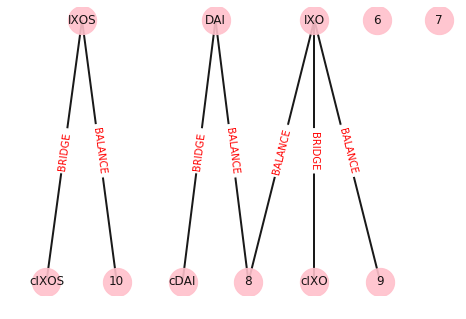

In [12]:
network, color_map = initialize_network()
pos = nx.drawing.nx_agraph.graphviz_layout(network, prog='dot') #spring_layout(network, k=0.15,iterations=20)

plt.figure()
nx.draw(
    network, pos, edge_color='black', width=2, linewidths=1,
    node_size=800, node_color='pink', alpha=0.9,
    labels={node: node for node in network.nodes()})

nx.draw_networkx_edge_labels(
    network, pos,
    edge_labels={(u,v): d['_type'] for u,v,d in network.edges(data=True)},
    font_color='red')

plt.axis('off')
plt.show()

#nx.draw_kamada_kawai(network, node_color=color_map, font_weight='bold', with_labels=True)

initial_state.update({
    'network': network,
})

### Configure cadCAD

In [13]:
runs = 1 # Monte Carlo runs

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps

simulation_parameters = config_sim({
    'T': range(time_steps),
    'N': runs,
    'M': params
})
simulation_parameters

[{'N': 1,
  'T': range(0, 360),
  'M': {'amm.kappa': 1.2,
   'amm.tax_rate': 0.02,
   'amm.theta': 0,
   'arbitrage_roi': 0.05,
   'brk.trade_fee': 0.02,
   'brk.sanity_rate': 10,
   'brk.reasonable_diff': 0.5,
   'brk.rebalance_diff': False,
   'brk.max_spread': 0.02,
   'brk.min_spread': 0.005,
   'max_participants': 120,
   'participant_seed_collateral': 500,
   'supply_pool_tx_rate': 0,
   'supply_pool_tx_count': 5,
   'supply_pool_tx_value': 1000000.0,
   'daily_service_fee': 2,
   'sweep': 1}},
 {'N': 1,
  'T': range(0, 360),
  'M': {'amm.kappa': 1.2,
   'amm.tax_rate': 0.5,
   'amm.theta': 0,
   'arbitrage_roi': 0.05,
   'brk.trade_fee': 0.02,
   'brk.sanity_rate': 10,
   'brk.reasonable_diff': 0.5,
   'brk.rebalance_diff': False,
   'brk.max_spread': 0.02,
   'brk.min_spread': 0.005,
   'max_participants': 120,
   'participant_seed_collateral': 500,
   'supply_pool_tx_rate': 0,
   'supply_pool_tx_count': 5,
   'supply_pool_tx_value': 1000000.0,
   'daily_service_fee': 2,
   'sw

### Perform Simulation

In [14]:
# ts_format = '%Y-%m-%d %H:%M:%S'
# t_delta = timedelta(days=30, minutes=0, seconds=0)
# def time_model(_g, step, sL, s, _input):
#     y = 'time'
#     x = ep_time_step(s, dt_str=s['time'], fromat_str=ts_format, _timedelta=t_delta)
#     return (y, x)

# exogenous_states = {
# #     'time': time_model
# }
# env_processes = {}

partial_state_update_blocks = [
    { # Genesis
        'policies': {
            'genesis': check_genesis,
        },
        'variables': {
            'network': perform_genesis,
        }
    },
    { # Generate new participants
        'policies': {
            'generate': driving_process,
        },
        'variables': {
            'network': update_network,
        }
    },
    { # Actors enter supply pool
        'policies': {
            'supply': supply_pool_process,
        },
        'variables': {
            'network': update_balances,
        }
    },
    { # Actors provide liquidity via brokerage
        'policies': {
            'liquidity': liquidity_pool_process,
        },
        'variables': {
            'network': update_brokerage,
        }
    },
    {
        'policies': {
            'activity': participant_process,
        },
        'variables': {
            'network': update_brokerage,
        }
    },
    {
        'policies': {
            'arbitrage': arbitrage_process,
        },
        'variables': {
            'network': perform_arbitrage,
        }
    },
    {
        'policies': {
            'fees': collect_fee_process,
        },
        'variables': {
            'network': collect_fees,
        }
    },
#     { # Brokerage rebalance
#         'policies': {
#             'rebalance': brokerage_rebalance,
#         },
#         'variables': {
#             'network': update_brokerage,
#         }
#     },
    { # Accounting
        'policies': {
            'accounting': accounting,
        },
        'variables': {
            'amm.supply': update_supply,
            'amm.reserve': update_reserve,
            'amm.spot_price': update_spot_price,
            'lp.spot_price': update_lp_spot_price,
            'lp.voucher_price': update_lp_voucher_price,
        }
    },
#     { # Sync networks
#         'policies': {
#             'sync': sync,
#         },
#         'variables': {
#             'network': sync_bridges,
#         }
#     }
]

In [15]:
append_configs(
    initial_state=initial_state, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters, #dict containing simulation parameters
#     raw_exogenous_states=exogenous_states,
#     env_processes=env_processes
)

sys.setrecursionlimit(10000)
from cadCAD import configs

exec_mode = ExecutionMode()
exec_context = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=exec_context, configs=configs)

i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1

[{'N': 1, 'T': range(0, 360), 'M': {'amm.kappa': 1.2, 'amm.tax_rate': 0.02, 'amm.theta': 0, 'arbitrage_roi': 0.05, 'brk.trade_fee': 0.02, 'brk.sanity_rate': 10, 'brk.reasonable_diff': 0.5, 'brk.rebalance_diff': False, 'brk.max_spread': 0.02, 'brk.min_spread': 0.005, 'max_participants': 120, 'participant_seed_collateral': 500, 'supply_pool_tx_rate': 0, 'supply_pool_tx_count': 5, 'supply_pool_tx_value': 1000000.0, 'daily_service_fee': 2, 'sweep': 1}}, {'N': 1, 'T': range(0, 360), 'M': {'amm.kappa': 1.2, 'amm.tax_rate': 0.5, 'amm.theta': 0, 'arbitrage_roi': 0.05, 'brk.trade_fee': 0.02, 'brk.sanity_rate': 10, 'brk.reasonable_diff': 0.5, 'brk.rebalance_diff': False, 'brk.max_spread': 0.02, 'brk.min_spread': 0.005, 'max_participants': 120, 'participant_seed_collateral': 500, 'supply_pool_tx_rate': 0, 'supply_pool_tx_count': 5, 'supply_pool_tx_value': 1000000.0, 'daily_service_fee': 2, 'sweep': 2}}]
[{'N': 1, 'T': range(0, 360), 'M': {'amm.kappa': 1.2, 'amm.tax_rate': 0.02, 'amm.theta': 0, 'a

# Model Data Analysis

In [16]:
# Choose which experiment parameter configuration to use, integer starting from zero
import os

def select_experiment(results, i):
    df = pd.DataFrame(results[i - 1]['result'])
    directory = './experiment_%s/' % i
    if not os.path.exists(directory):
        os.makedirs(directory)
    return df[df.substep==len(partial_state_update_blocks)].copy()

def save_experiment(fig, experiment, name):
    pickle.dump(fig, open('experiment_%s/%s.pickle' % (experiment, name), 'wb'))
    fig.savefig('experiment_%s/%s.png' % (experiment, name))

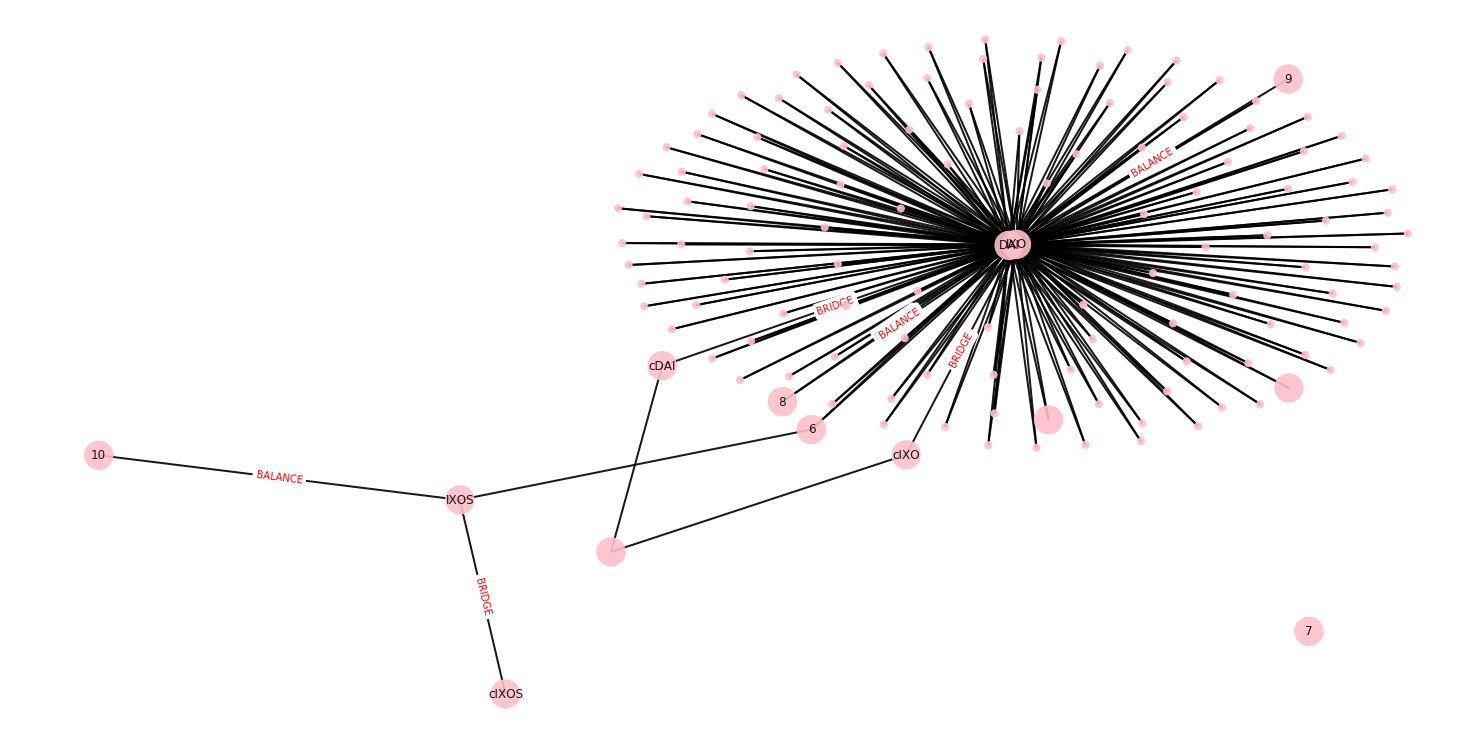

In [17]:
rdf = select_experiment(results, 1)
network_output = rdf['network'][rdf.index[-1]]

pos = nx.drawing.nx_agraph.graphviz_layout(network_output, prog='neato') #spring_layout(network, k=0.15,iterations=20)

node_sizes = [50 if network_output.nodes[node]['_type'] == Nodes.PARTICIPANT.name else 800 for node in network_output.nodes()]

plt.figure(1,figsize=(20,10))
nx.draw(
    network_output, pos, edge_color='black', width=2, linewidths=1,
    node_size=node_sizes, node_color='pink', alpha=0.9,
    labels={node: node for node in network.nodes()})

nx.draw_networkx_edge_labels(
    network_output, pos,
    edge_labels={(u,v): d['_type'] for u,v,d in network.edges(data=True)},
    font_color='red')

plt.axis('off')
plt.show()

In [18]:
select_experiment(results, 1)

,,amm.invariant,amm.reserve,amm.spot_price,amm.supply,lp.reserve,lp.spot_price,lp.supply,lp.voucher_price,network,run,substep,timestep,valid_system_state
8,,0,0.000000e+00,0.000000,0.000000e+00,0,0.000000,0,0.000000,"(IXOS, cIXOS, DAI, cDAI, IXO, cIXO, 6, 7, 8, 9...",1,8,1,True
16,,0,2.490743e+08,0.179989,1.660596e+09,0,0.000000,0,0.000000,"(IXOS, cIXOS, DAI, cDAI, IXO, cIXO, 6, 7, 8, 9...",1,8,2,True
24,,0,2.490743e+08,0.179989,1.660596e+09,0,0.000000,0,0.000000,"(IXOS, cIXOS, DAI, cDAI, IXO, cIXO, 6, 7, 8, 9...",1,8,3,True
32,,0,2.490743e+08,0.179989,1.660596e+09,0,0.000000,0,0.000000,"(IXOS, cIXOS, DAI, cDAI, IXO, cIXO, 6, 7, 8, 9...",1,8,4,True
40,,0,2.490743e+08,0.179989,1.660596e+09,0,0.000000,0,0.000000,"(IXOS, cIXOS, DAI, cDAI, IXO, cIXO, 6, 7, 8, 9...",1,8,5,True
48,,0,2.490743e+08,0.179989,1.660596e+09,0,0.000000,0,0.000000,"(IXOS, cIXOS, DAI, cDAI, IXO, cIXO, 6, 7, 8, 9...",1,8,6,True
56,,0,2.490743e+08,0.179989,1.660596e+09,0,0.000000,0,0.000000,"(IXOS, cIXOS, DAI, cDAI, IXO, cIXO, 6, 7, 8, 9...",1,8,7,True
64,,0,2.490743e+08,0.179989,1.660596e+09,0,0.000000,0,0.000000,"(IXOS, cIXOS, DAI, cDAI, IXO, cIXO, 6, 7, 8, 9...",1,8,8,True
72,,0,2.490743e+08,0.179989,1.660596e+09,0,0.000000,0,0.000000,"(IXOS, cIXOS, DAI, cDAI, IXO, cIXO, 6, 7, 8, 9...",1,8,9,True
80,,0,2.490743e+08,0.179989,1.660596e+09,0,0.000000,0,0.000000,"(IXOS, cIXOS, DAI, cDAI, IXO, cIXO, 6, 7, 8, 9...",1,8,10,True


Minimum spot price 0.1799891605160393
Maximum spot price 0.1805650552821373
Minimum spot price 0.1799891605160393
Maximum spot price 0.18058637806597255


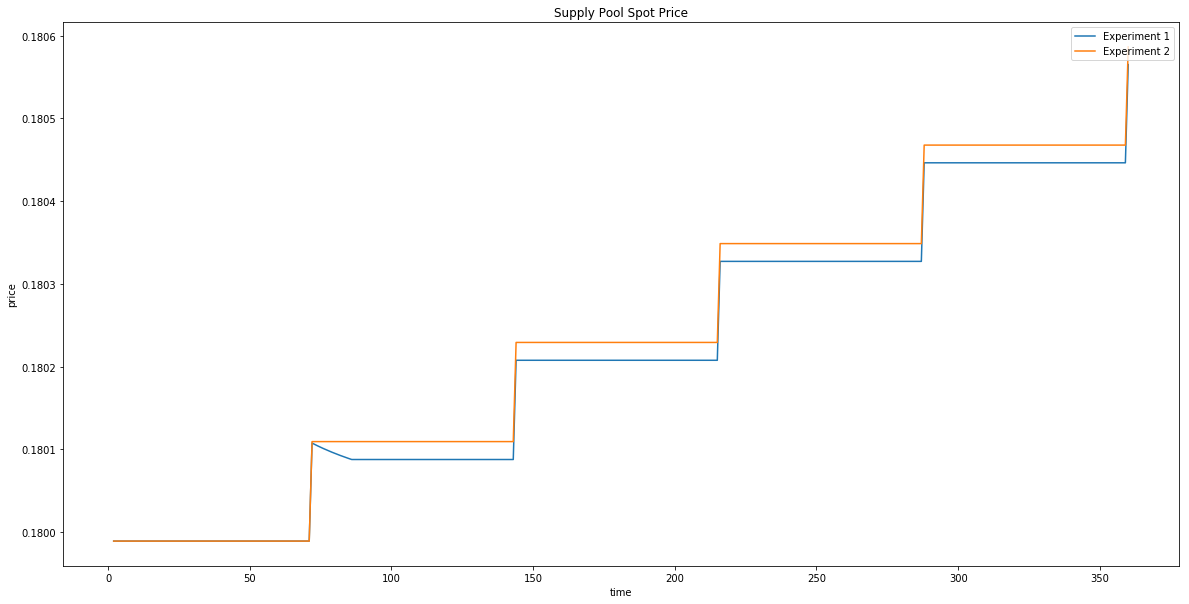

In [19]:
for experiment in params['sweep']:
    data_id = 'amm.spot_price'
    rdf = select_experiment(results, experiment)
    rdf = rdf[rdf[data_id] > 0]

    fig = plt.figure(1,figsize=(20,10))
    #data = make2D('IXO_pool_growth', rdf)
    plt.plot(rdf.timestep, rdf[data_id], label="Experiment %s" % experiment)
    plt.title('Supply Pool Spot Price')
    plt.xlabel('time')
    plt.ylabel('price')

    save_experiment(fig, experiment, data_id)
    print('Minimum spot price %s' % min(rdf[data_id]))
    print('Maximum spot price %s' % max(rdf[data_id]))
    
plt.legend(loc='upper right')

Minimum spot price 0.10367082803888333
Maximum spot price 0.17233763158386767
Minimum spot price 0.10010901108824448
Maximum spot price 0.10947382895918883


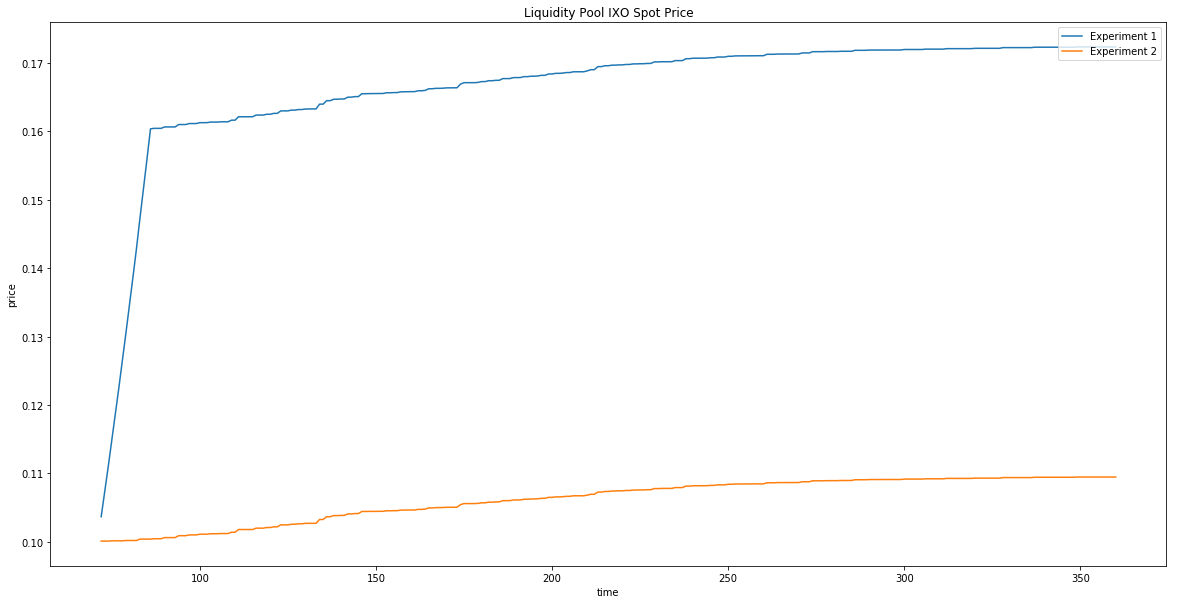

In [20]:
for experiment in params['sweep']:
    data_id = 'lp.spot_price'
    rdf = select_experiment(results, experiment)
    rdf = rdf[rdf[data_id] > 0]

    fig = plt.figure(1,figsize=(20,10))
    #data = make2D('IXO_pool_growth', rdf)
    plt.plot(rdf.timestep, rdf[data_id], label="Experiment %s" % experiment)
    plt.title('Liquidity Pool IXO Spot Price')
    plt.xlabel('time')
    plt.ylabel('price')

    save_experiment(fig, experiment, data_id)
    print('Minimum spot price %s' % min(i for i in rdf[data_id] if i > 0))
    print('Maximum spot price %s' % max(rdf[data_id]))

plt.legend(loc='upper right')

Minimum spot price 0.20370566184281794
Maximum spot price 0.26331295062184246
Minimum spot price 0.20014068589250011
Maximum spot price 0.20938714003979383


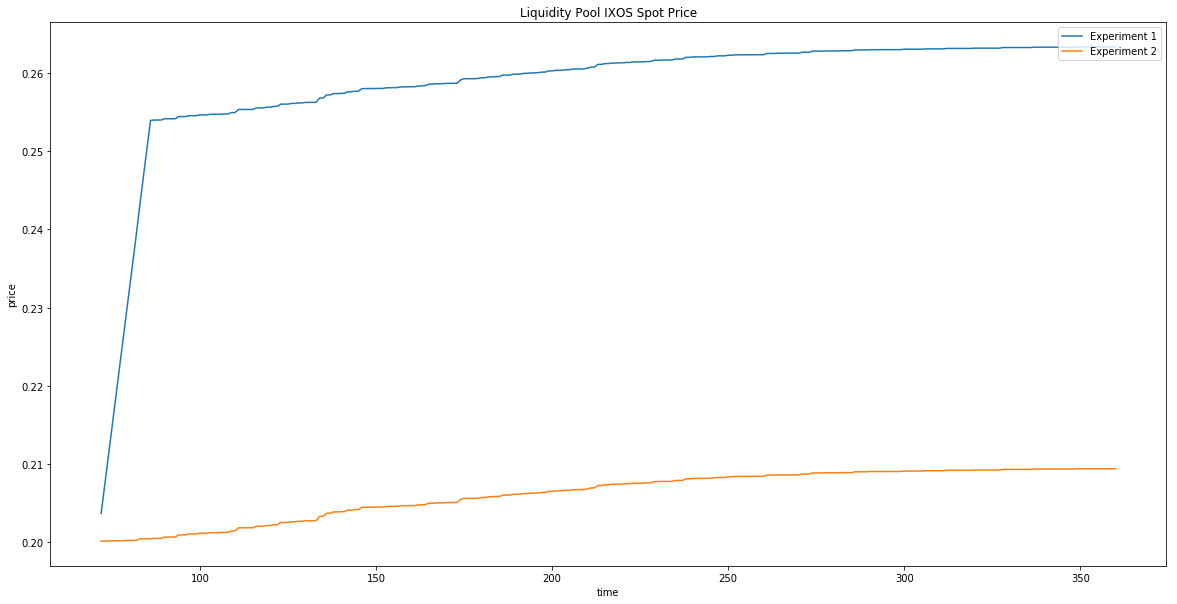

In [21]:
for experiment in params['sweep']:
    data_id = 'lp.voucher_price'
    rdf = select_experiment(results, experiment)
    rdf = rdf[rdf[data_id] > 0]

    fig = plt.figure(1,figsize=(20,10))
    #data = make2D('IXO_pool_growth', rdf)
    plt.plot(rdf.timestep, rdf[data_id], label="Experiment %s" % experiment)
    plt.title('Liquidity Pool IXOS Spot Price')
    plt.xlabel('time')
    plt.ylabel('price')

    save_experiment(fig, experiment, data_id)
    print('Minimum spot price %s' % min(i for i in rdf[data_id] if i > 0))
    print('Maximum spot price %s' % max(rdf[data_id]))

plt.legend(loc='upper right')

Minimum 10000.0
Maximum 60752.159651852846
Minimum 10000
Maximum 10000


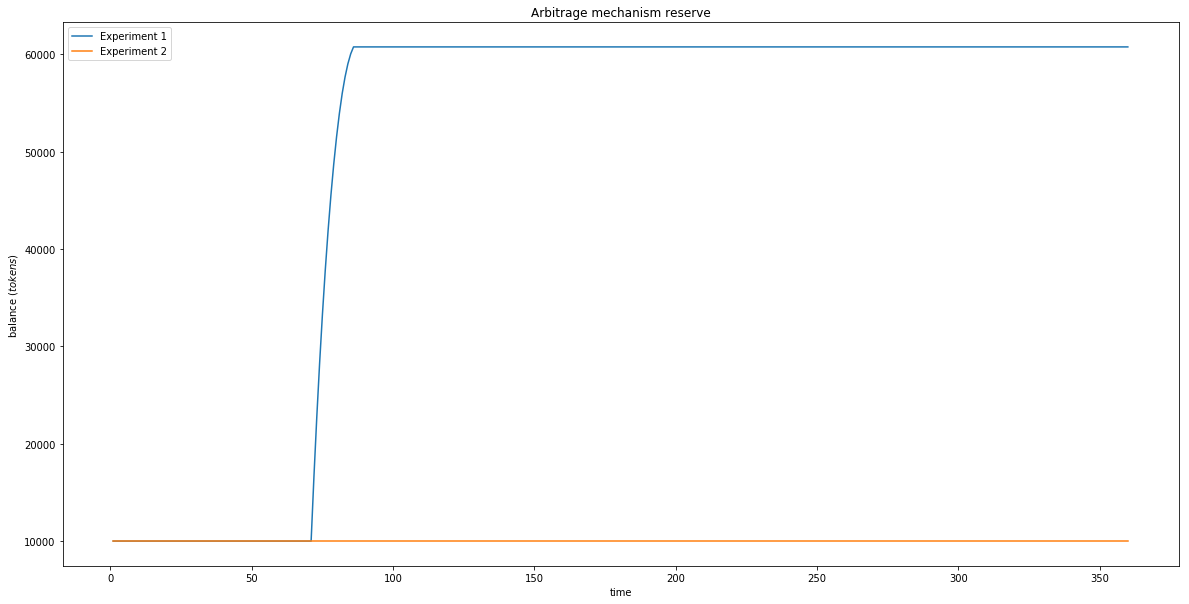

In [22]:
generic_actor_type = Nodes.ARBITRAGE.name
actor = get_node_ids_of_type(network, generic_actor_type)[0]

for experiment in params['sweep']:
    data_id = 'arbitrage_mechanism_reserve'
    
    rdf = select_experiment(results, experiment)
    rdf[data_id] = rdf['network'].apply(lambda g: balance_of(g, actor, 'DAI'))

    fig = plt.figure(1,figsize=(20,10))
    #data = make2D('IXO_pool_growth', rdf)
    plt.plot(rdf.timestep, rdf[data_id], label="Experiment %s" % experiment)
    plt.title('Arbitrage mechanism reserve')
    plt.xlabel('time')
    plt.ylabel('balance ($tokens$)')

    save_experiment(fig, experiment, data_id)
    print('Minimum %s' % min(rdf[data_id]))
    print('Maximum %s' % max(rdf[data_id]))
    
plt.legend(loc='upper left')

Minimum 1660595658.0
Maximum 1687194210.2661958
Minimum 1660595658.0
Maximum 1688328996.3798742


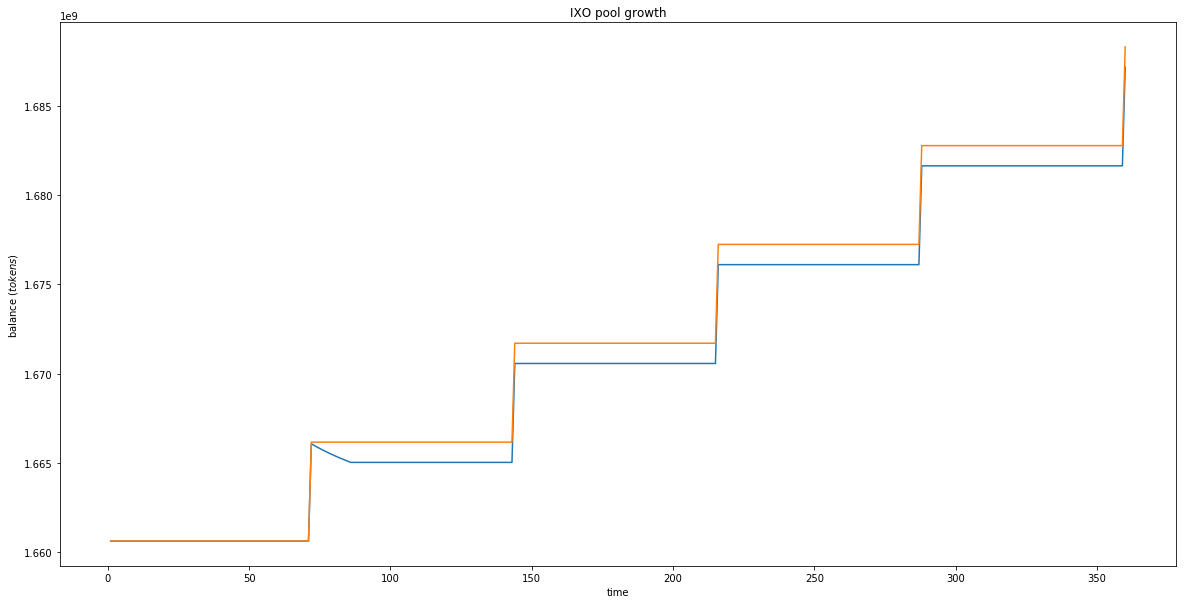

In [23]:
for experiment in params['sweep']:
    rdf = select_experiment(results, experiment)
    rdf['IXO_pool_growth'] = rdf['network'].apply(lambda g: get_pool_balance(g, 'IXO'))

    fig = plt.figure(1,figsize=(20,10))
    #data = make2D('IXO_pool_growth', rdf)
    plt.plot(rdf.timestep, rdf['IXO_pool_growth'])
    plt.title('IXO pool growth')
    plt.xlabel('time')
    plt.ylabel('balance ($tokens$)')

    save_experiment(fig, experiment, 'IXO_pool_growth')
    print('Minimum %s' % min(rdf['IXO_pool_growth']))
    print('Maximum %s' % max(rdf['IXO_pool_growth']))

Minimum 0.0
Maximum 29410672.95488087
Minimum 0.0
Maximum 28100235.0179224


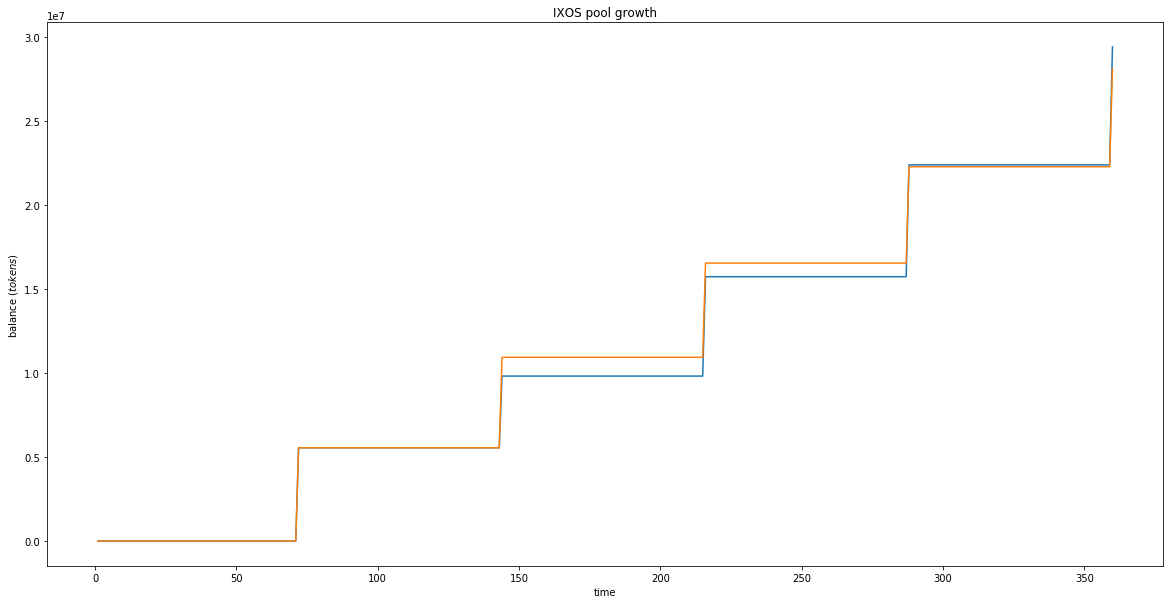

In [24]:
for experiment in params['sweep']:
    data_id = 'IXOS_pool_growth'
    rdf = select_experiment(results, experiment)
    rdf[data_id] = rdf['network'].apply(lambda g: get_pool_balance(g, 'IXOS'))

    fig = plt.figure(1,figsize=(20,10))
    #data = make2D('IXO_pool_growth', rdf)
    plt.plot(rdf.timestep, rdf[data_id])
    plt.title('IXOS pool growth')
    plt.xlabel('time')
    plt.ylabel('balance ($tokens$)')

    save_experiment(fig, experiment, data_id)
    print('Minimum %s' % min(rdf[data_id]))
    print('Maximum %s' % max(rdf[data_id]))

Minimum 249085371.93948993
Maximum 259137566.5904065
Minimum 249085371.93948993
Maximum 259137566.5904066


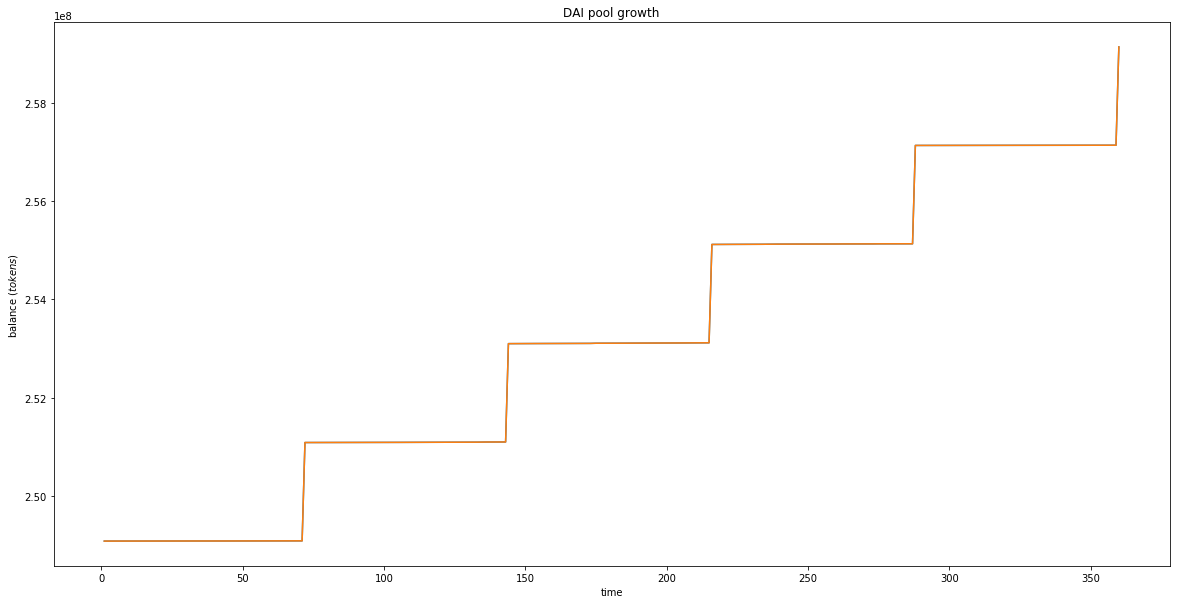

In [25]:
for experiment in params['sweep']:
    rdf = select_experiment(results, experiment)
    rdf['DAI_pool_growth'] = rdf['network'].apply(lambda g: get_pool_balance(g, 'DAI'))

    fig = plt.figure(1,figsize=(20,10))
    #data = make2D('IXO_pool_growth', rdf)
    plt.plot(rdf.timestep, rdf['DAI_pool_growth'])
    plt.title('DAI pool growth')
    plt.xlabel('time')
    plt.ylabel('balance ($tokens$)')

    save_experiment(fig, experiment, 'IXO_pool_growth')
    print('Minimum %s' % min(rdf['DAI_pool_growth']))
    print('Maximum %s' % max(rdf['DAI_pool_growth']))

Minimum 249074348.7
Maximum 253873596.54034805
Minimum 249074348.7
Maximum 254074348.7


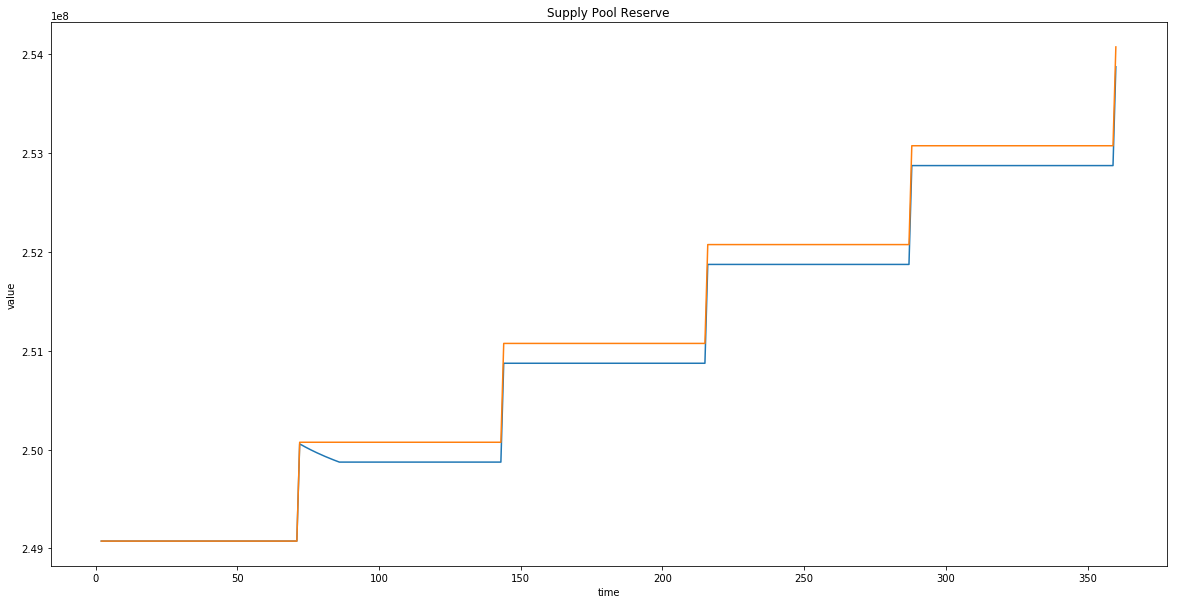

In [26]:
for experiment in params['sweep']:
    data_id = 'amm.reserve'
    rdf = select_experiment(results, experiment)
    rdf = rdf[rdf[data_id] > 0]

    fig = plt.figure(1,figsize=(20,10))
    #data = make2D('IXO_pool_growth', rdf)
    plt.plot(rdf.timestep, rdf[data_id])
    plt.title('Supply Pool Reserve')
    plt.xlabel('time')
    plt.ylabel('value')

    save_experiment(fig, experiment, data_id)
    print('Minimum %s' % min(rdf[data_id]))
    print('Maximum %s' % max(rdf[data_id]))

Minimum 1660595658.0
Maximum 1687194210.2661958
Minimum 1660595658.0
Maximum 1688328996.3798742


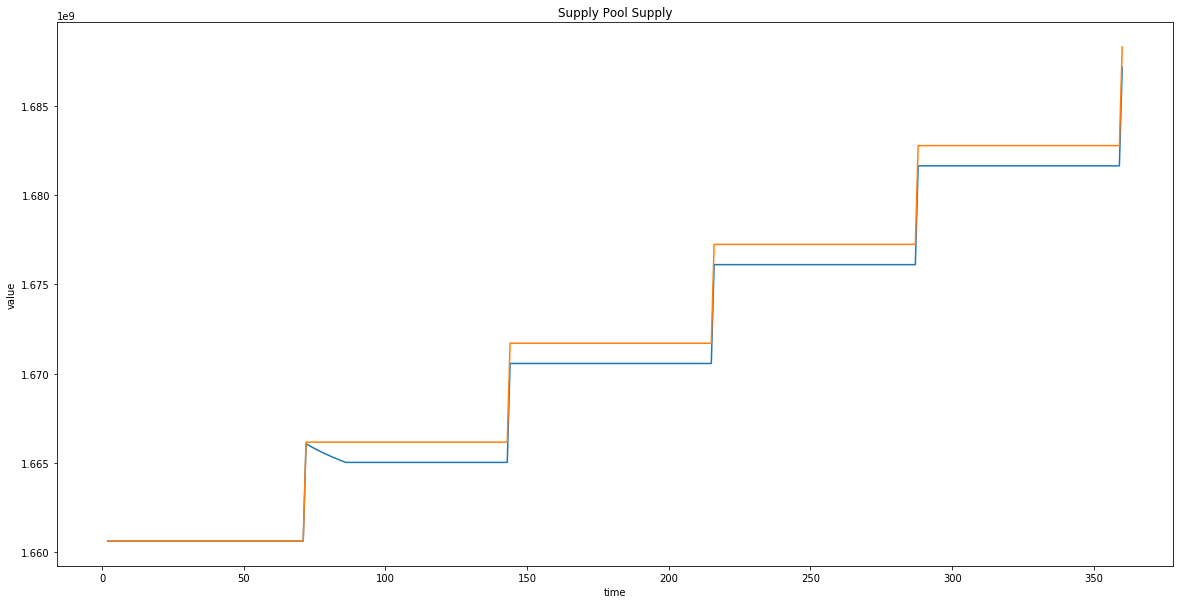

In [27]:
market_maker_id = generate_pair_id(Nodes.MARKET_MAKER, ('DAI', 'IXO'))
edge_id = (market_maker_id, 'DAI')

for experiment in params['sweep']:
    data_id = 'amm.supply'
    rdf = select_experiment(results, experiment)
    rdf = rdf[rdf[data_id] > 0]

    fig = plt.figure(1,figsize=(20,10))
    #data = make2D('IXO_pool_growth', rdf)
    plt.plot(rdf.timestep, rdf[data_id])
    plt.title('Supply Pool Supply')
    plt.xlabel('time')
    plt.ylabel('value')

    save_experiment(fig, experiment, data_id)
    print('Minimum %s' % min(rdf[data_id]))
    print('Maximum %s' % max(rdf[data_id]))

Minimum 0
Maximum 39550
Minimum 0
Maximum 40340


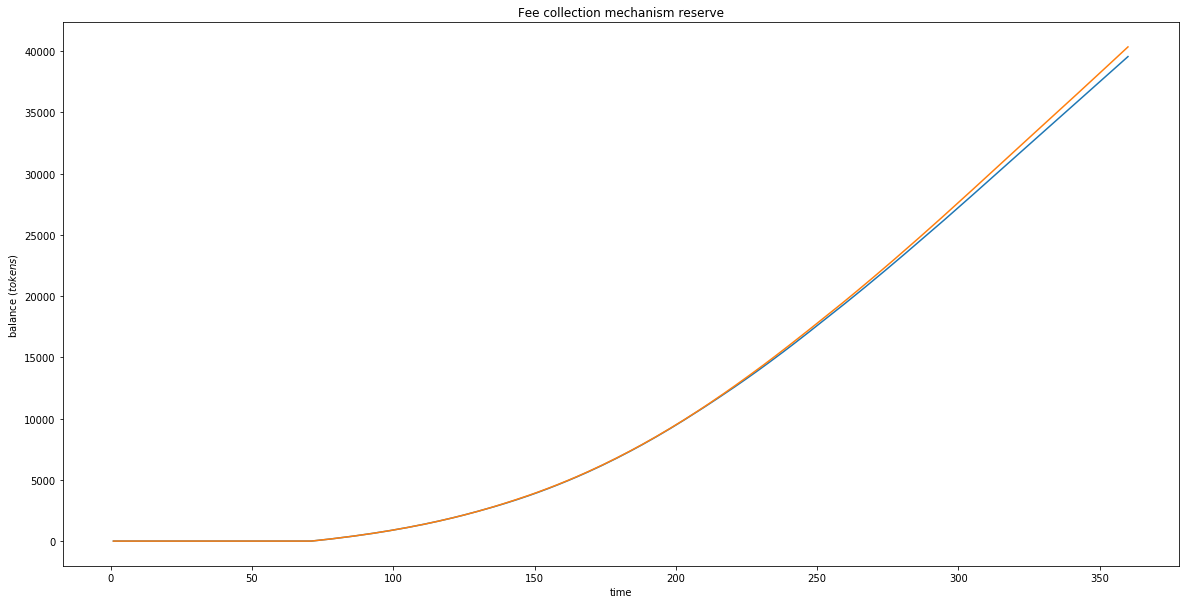

In [28]:
generic_actor_type = Nodes.FEE_POOL.name
actor = get_node_ids_of_type(network, generic_actor_type)[0]

for experiment in params['sweep']:
    data_id = 'fee_collection_mechanism_reserve'
    
    rdf = select_experiment(results, experiment)
    rdf[data_id] = rdf['network'].apply(lambda g: balance_of(g, actor, 'IXO'))

    fig = plt.figure(1,figsize=(20,10))
    #data = make2D('IXO_pool_growth', rdf)
    plt.plot(rdf.timestep, rdf[data_id])
    plt.title('Fee collection mechanism reserve')
    plt.xlabel('time')
    plt.ylabel('balance ($tokens$)')

    save_experiment(fig, experiment, data_id)
    print('Minimum %s' % min(rdf[data_id]))
    print('Maximum %s' % max(rdf[data_id]))

Minimum 571408.2357965341
Maximum 3911217.7794160517
Minimum 561408.2357965341
Maximum 2971630.2759657437


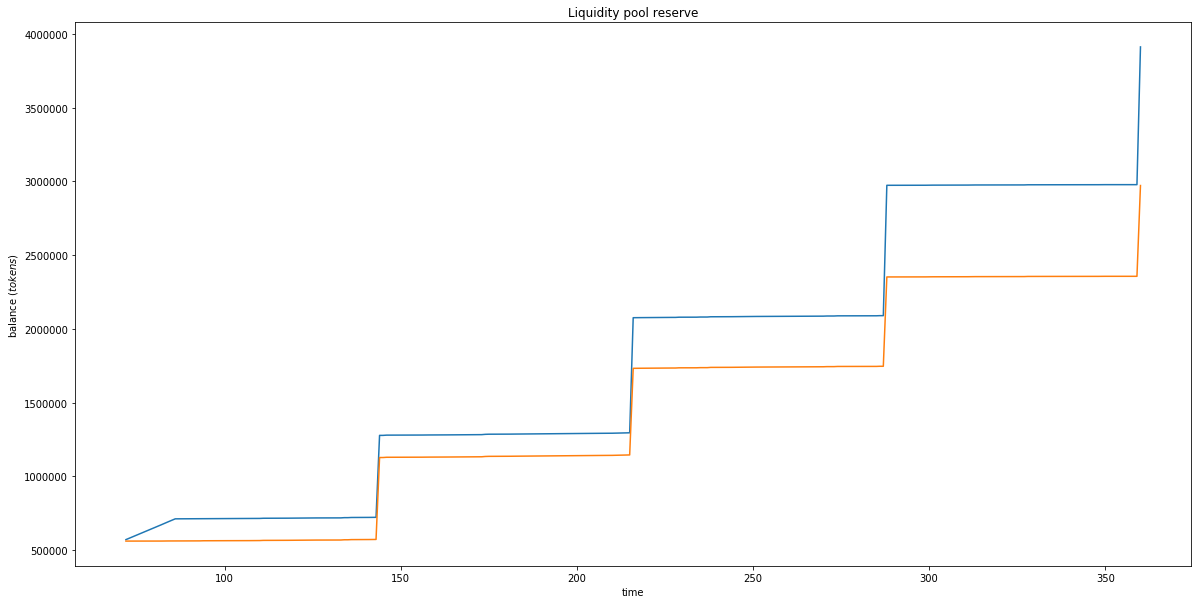

In [29]:
handler_id = generate_pair_id(Nodes.BROKERAGE, ('DAI', 'IXO'))

for experiment in params['sweep']:
    data_id = 'brokerage_pool_reserve'
    
    rdf = select_experiment(results, experiment)
    rdf[data_id] = rdf['network'].apply(lambda g: balance_of(g, handler_id, 'DAI'))
    rdf = rdf[rdf[data_id] > 0]

    fig = plt.figure(1,figsize=(20,10))
    #data = make2D('IXO_pool_growth', rdf)
    plt.plot(rdf.timestep, rdf[data_id])
    plt.title('Liquidity pool reserve')
    plt.xlabel('time')
    plt.ylabel('balance ($tokens$)')

    save_experiment(fig, experiment, data_id)
    print('Minimum %s' % min(rdf[data_id]))
    print('Maximum %s' % max(rdf[data_id]))

Minimum 4291669.947116272
Maximum 22241185.629103504
Minimum 5391103.374527008
Maximum 26601769.49001871


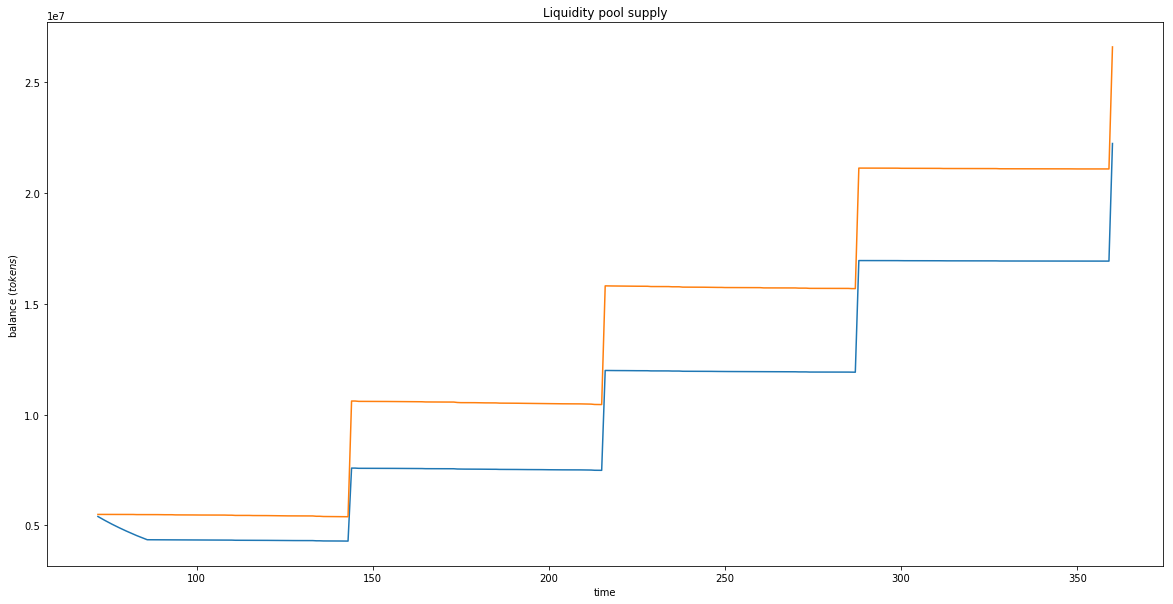

In [30]:
handler_id = generate_pair_id(Nodes.BROKERAGE, ('DAI', 'IXO'))

for experiment in params['sweep']:
    data_id = 'brokerage_pool_reserve'
    
    rdf = select_experiment(results, experiment)
    rdf[data_id] = rdf['network'].apply(lambda g: balance_of(g, handler_id, 'IXO'))
    rdf = rdf[rdf[data_id] > 0]

    fig = plt.figure(1,figsize=(20,10))
    #data = make2D('IXO_pool_growth', rdf)
    plt.plot(rdf.timestep, rdf[data_id])
    plt.title('Liquidity pool supply')
    plt.xlabel('time')
    plt.ylabel('balance ($tokens$)')

    save_experiment(fig, experiment, data_id)
    print('Minimum %s' % min(rdf[data_id]))
    print('Maximum %s' % max(rdf[data_id]))